In [1]:
import sys

In [2]:
BASE_DIR = "../.."
DATA_DIR = f"{BASE_DIR}/data"
NBDATA_DIR = f"{BASE_DIR}/nbdata"
FIG_DIR = f"{BASE_DIR}/figs"

In [3]:
sys.path.append(BASE_DIR)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [5]:
import anndata as ad
import scanpy as sc

## Load Name Mappings

In [6]:
hgnc_name_map = pd.read_csv(f"{NBDATA_DIR}/iPSC_ENSG_HGNC_mapping.tsv",sep="\t").set_index('ENSG')

als_mapping = pd.read_csv(f"{NBDATA_DIR}/iPSC_rna_als_genie_integer_edgelist_0.999_MAP.tsv",sep="\t",header=None)
als_name_dict = {}
for i, ensg in zip(als_mapping.iloc[:,1], als_mapping.iloc[:,0]):
    als_name_dict[i] = hgnc_name_map.loc[ensg,'HGNC']
    
ctr_mapping = pd.read_csv(f"{NBDATA_DIR}/iPSC_rna_ctr_genie_integer_edgelist_0.999_MAP.tsv",sep="\t",header=None)
ctr_name_dict = {}
for i, ensg in zip(ctr_mapping.iloc[:,1], ctr_mapping.iloc[:,0]):
    ctr_name_dict[i] = hgnc_name_map.loc[ensg,'HGNC']

## Load Motifs

In [7]:
out_basename = "../../nbdata/iPSC_rna_{}_genie_integer_edgelist_0.999_mfinder_s{}_OUT.txt"
member_basename = "../../nbdata/iPSC_rna_{}_genie_integer_edgelist_0.999_mfinder_s{}_MEMBERS.txt"

In [8]:
class GeneralMotif():
    
    def __init__(self,
                 size,
                 matrix,
                 motif_id,
                 nreal,
                 nrand_stats,
                 nreal_zscore,
                 nreal_pval
                ):
        self.motif_id = motif_id
        self.nreal = nreal
        self.nrand_stats = nrand_stats
        self.nreal_zscore = nreal_zscore
        self.nreal_pval = nreal_pval

        self.matrix = matrix
        self.size = size
        self.graph = nx.from_numpy_matrix(self.matrix,create_using=nx.DiGraph)
        assert self.matrix.shape[0] == self.size
        assert self.matrix.shape[1] == self.size
    
    def __lt__(self,other):
        return self.nreal_pval < other.nreal_pval
    
    def __eq__(self,other):
        return (self.matrix == other.matrix).all()
    
    def __repr__(self):
        return str(self.matrix)
    
    def __hash__(self):
        return hash(str(self.matrix))
    
    def view(self,savefig=None,do_hash=False,node_size=2000,node_color='lightgrey',**kwargs):
        sns.set(style='whitegrid',font_scale=1)
        fig, ax1 = plt.subplots(figsize=(8,6))
        nx.draw_networkx(self.graph,
                         arrows=True,
                         arrowsize=45,
                         node_size=node_size,
                         node_color=node_color,
                         ax=ax1,
                         **kwargs
                        )
        plt.axis('off')
        plt.title(f"Motif ID {self.motif_id} -- pvalue: {self.nreal_pval} {f'(hash={hash(self)})' if do_hash else ''}")
        if savefig:
            plt.savefig(savefig,bbox_inches='tight')
        plt.show()
        
    def make_specific(self, member_list):
        spec_motif = Motif(
            self.size,
            self.matrix,
            self.motif_id,
            self.nreal,
            self.nrand_stats,
            self.nreal_zscore,
            self.nreal_pval,
            member_list = member_list
        )
        return spec_motif
        
class Motif(GeneralMotif):
    
    def __init__(self, *args, member_list=[]):
        super().__init__(*args)
        self.members = member_list
        self.node_mapping = {}
        for i, nm in zip(range(self.size), self.members):
            self.node_mapping[i] = nm
        self.graph = nx.relabel_nodes(self.graph, self.node_mapping)
        
    def __hash__(self):
        return hash(str(self.matrix)+','.join(self.members))

def parse_mfinder_outfile(condition, size):
    motif_list = []
    finame = out_basename.format(condition,size)
    with open(finame,'r') as f:
        startread = False
        for line in f:
            line = line.strip()
            if 'Full list includes' in line:
                startread = True
                f.readline() # Header line 1
                f.readline() # Header line 2
                f.readline() # Blank line
            elif 'Full list of subgraphs size' in line:
                startread = False
            elif not startread:
                continue
            else:
                try:
                    # In a block
                    mid, nreal, nrand_stats, nreal_z, nreal_p, uniq_val, creal = line.split()
                    f.readline() # Blank line
                    motif_matrix = []
                    for _ in range(size): # Read motif identity
                        motif_matrix.append([int(i) for i in f.readline().strip().split()])
                    motif_matrix = np.array(motif_matrix)
                    motif_list.append(
                        GeneralMotif(
                            size,
                            motif_matrix,
                            int(mid),
                            float(nreal),
                            nrand_stats,
                            float(nreal_z),
                            float(nreal_p),
                        )
                    )
                    f.readline() # Blank line
                except ValueError as e:
                    return motif_list
                
def parse_mfinder_memberfile(condition, size, mlist = None, name_map = None):
    if mlist is None:
        mlist = parse_mfinder_outfile(condition, size)
    finame = member_basename.format(condition, size)
    mdict = {int(m.motif_id): m for m in mlist}
    all_motifs = []
    with open(finame,'r') as f:
        for line in f:
            if line.startswith('subgraph id'):
                mid = int(line.split('=')[1].strip())
                if not mid in mdict.keys():
                    continue
                else:
                    mot = mdict[mid]
                    nreal = int(f.readline().split(':')[1].strip())
                    f.readline() # Divider
                    f.readline() # Full list of X members
                    f.readline() # Blank line
                    for _ in range(nreal):
                        members = f.readline().strip().split()
                        if name_map:
                            members = [name_map[int(i)] for i in members]
                        all_motifs.append(mot.make_specific(members))
        return mlist, all_motifs

In [9]:
als_3_general, als_3_mlist = parse_mfinder_memberfile('als',3,name_map=als_name_dict)
ctr_3_general, ctr_3_mlist = parse_mfinder_memberfile('ctr',3,name_map=ctr_name_dict)
als_4_general, als_4_mlist = parse_mfinder_memberfile('als',4,name_map=als_name_dict)
ctr_4_general, ctr_4_mlist = parse_mfinder_memberfile('ctr',4,name_map=ctr_name_dict)
als_5_general, als_5_mlist = parse_mfinder_memberfile('als',5,name_map=als_name_dict)

In [175]:
als_5_general = parse_mfinder_outfile('als',5)
ctr_5_general = parse_mfinder_outfile('ctr',5)
als_all_general = set(als_3_general).union(als_4_general).union(als_5_general)
ctr_all_general = set(ctr_3_general).union(ctr_4_general).union(ctr_5_general)
als_only_motifs = sorted(list(als_all_general.difference(ctr_all_general)),key=lambda x: x.size)
als_only_mids = [m.motif_id for m in als_only_motifs]

In [176]:
als_only_3_spec = [m for m in als_3_mlist if m.motif_id in als_only_mids]
als_only_4_spec = [m for m in als_4_mlist if m.motif_id in als_only_mids]
als_only_5_spec = [m for m in als_5_mlist if m.motif_id in als_only_mids]

## Load GSEA Results

In [141]:
gsea_results = pd.read_csv(f"{NBDATA_DIR}/gsea/iPSC/gsea_report_for_ALS_1651153870433.tsv",sep="\t",index_col=0)

In [155]:
gsea_results.head(20)

,GS<br> follow link to MSigDB,GS DETAILS,SIZE,ES,NES,NOM p-val,FDR q-val,FWER p-val,RANK AT MAX,LEADING EDGE,Unnamed: 11
NAME,,,,,,,,,,,
GO_BRAIN_MORPHOGENESIS,GO_BRAIN_MORPHOGENESIS,Details ...,33,0.580715,1.916040,0.002020,1.000000,0.387,2590,"tags=27%, list=9%, signal=30%",NaN
GO_ENDODERM_DEVELOPMENT,GO_ENDODERM_DEVELOPMENT,Details ...,65,0.649111,1.909575,0.004032,0.855984,0.412,4976,"tags=51%, list=17%, signal=61%",NaN
GO_ENDODERM_FORMATION,GO_ENDODERM_FORMATION,Details ...,46,0.662366,1.896858,0.005882,0.681832,0.446,4647,"tags=54%, list=16%, signal=65%",NaN
GO_REGULATION_OF_PATHWAY_RESTRICTED_SMAD_PROTEIN_PHOSPHORYLATION,GO_REGULATION_OF_PATHWAY_RESTRICTED_SMAD_PROTE...,Details ...,54,0.657260,1.882632,0.000000,0.628835,0.487,4653,"tags=50%, list=16%, signal=60%",NaN
GO_POSITIVE_REGULATION_OF_SMOOTHENED_SIGNALING_PATHWAY,GO_POSITIVE_REGULATION_OF_SMOOTHENED_SIGNALING...,Details ...,24,0.692590,1.877154,0.000000,0.542701,0.503,6743,"tags=67%, list=23%, signal=87%",NaN
GO_ENDODERMAL_CELL_DIFFERENTIATION,GO_ENDODERMAL_CELL_DIFFERENTIATION,Details ...,38,0.692800,1.861424,0.011696,0.557227,0.540,4536,"tags=58%, list=16%, signal=69%",NaN
GO_SYNAPSE_ASSEMBLY,GO_SYNAPSE_ASSEMBLY,Details ...,67,0.608795,1.855109,0.000000,0.516864,0.560,5369,"tags=43%, list=19%, signal=53%",NaN
GO_ESTROUS_CYCLE,GO_ESTROUS_CYCLE,Details ...,16,0.728045,1.846695,0.000000,0.504902,0.581,4570,"tags=56%, list=16%, signal=67%",NaN
GO_POSITIVE_REGULATION_OF_PATHWAY_RESTRICTED_SMAD_PROTEIN_PHOSPHORYLATION,GO_POSITIVE_REGULATION_OF_PATHWAY_RESTRICTED_S...,Details ...,43,0.634181,1.846332,0.000000,0.450747,0.582,4653,"tags=47%, list=16%, signal=55%",NaN


In [143]:
gsea_topgenes = pd.read_csv(f"{NBDATA_DIR}/gsea/iPSC/ranked_gene_list_ALS_versus_CTR_1651153870433.tsv",sep="\t",index_col=0)
gsea_genelist = gsea_topgenes.head(500).index.values

In [144]:
gsea_sig = gsea_results[gsea_results.loc[:,"NOM p-val"] <= 0.05]

In [145]:
gsea_endoderm = gsea_sig[gsea_sig.index.str.contains('ENDODERM')]

In [146]:
gsea_endoderm

,GS<br> follow link to MSigDB,GS DETAILS,SIZE,ES,NES,NOM p-val,FDR q-val,FWER p-val,RANK AT MAX,LEADING EDGE,Unnamed: 11
NAME,,,,,,,,,,,
GO_ENDODERM_DEVELOPMENT,GO_ENDODERM_DEVELOPMENT,Details ...,65,0.649111,1.909575,0.004032,0.855984,0.412,4976,"tags=51%, list=17%, signal=61%",NaN
GO_ENDODERM_FORMATION,GO_ENDODERM_FORMATION,Details ...,46,0.662366,1.896858,0.005882,0.681832,0.446,4647,"tags=54%, list=16%, signal=65%",NaN
GO_ENDODERMAL_CELL_DIFFERENTIATION,GO_ENDODERMAL_CELL_DIFFERENTIATION,Details ...,38,0.692800,1.861424,0.011696,0.557227,0.540,4536,"tags=58%, list=16%, signal=69%",NaN


In [147]:
gsea_dfs = {}

for go_term in gsea_endoderm.index:
    gsea_dfs[go_term] = pd.read_csv(f"{NBDATA_DIR}/gsea/iPSC/{go_term}.tsv",sep="\t",index_col=1)

In [148]:
gsea_endoderm_enriched_genes = set()

for go_term in gsea_endoderm.index:
    x = set(gsea_dfs[go_term][gsea_dfs[go_term]['CORE ENRICHMENT'].str.contains('Yes')].index.values)
    gsea_endoderm_enriched_genes = set.union(
        gsea_endoderm_enriched_genes, x
    )
gsea_endoderm_enriched_genes = sorted(list(gsea_endoderm_enriched_genes))

In [180]:
interesting_motifs = []

for alsm in (als_3_mlist + als_4_mlist + als_5_mlist):
# for alsm in (als_only_3_spec + als_only_4_spec + als_only_5_spec):
    if len(set(alsm.members).intersection(gsea_endoderm_enriched_genes)) >= 2:
        interesting_motifs.append(alsm)
len(interesting_motifs)

44

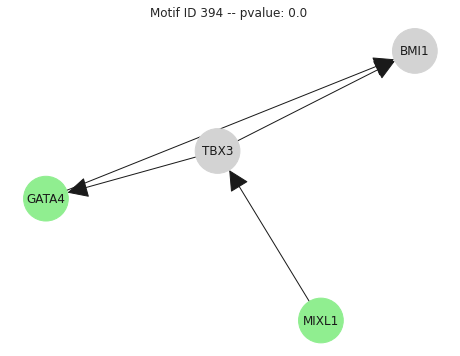

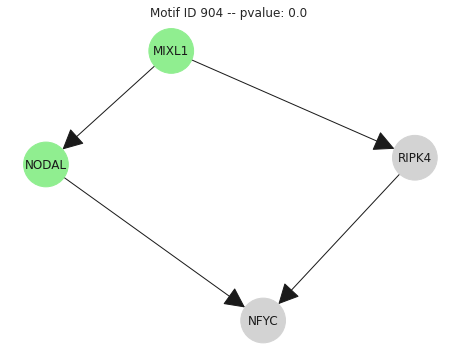

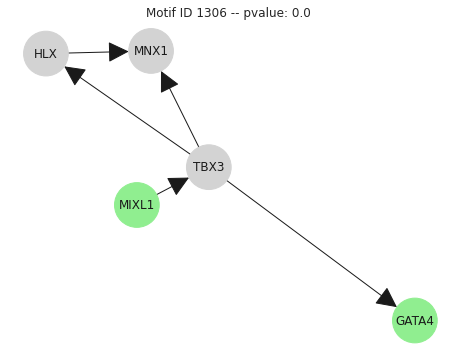

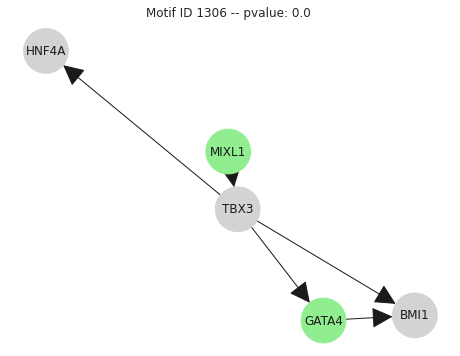

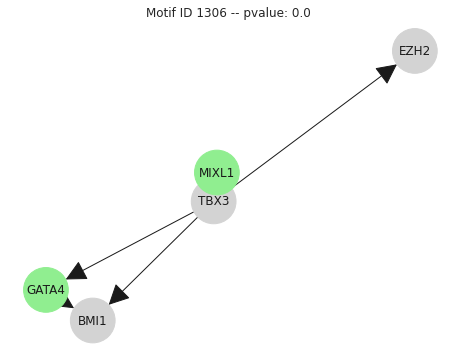

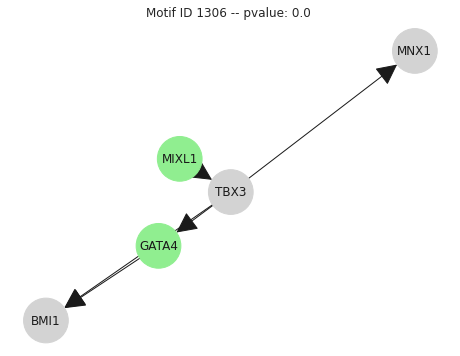

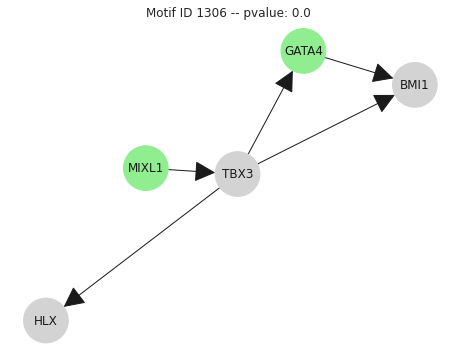

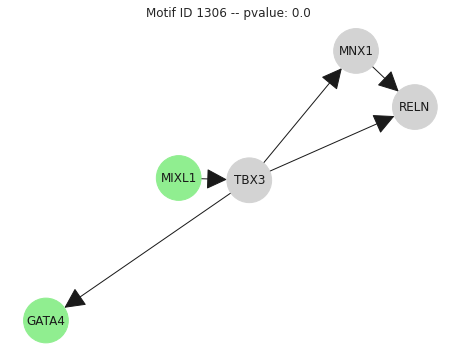

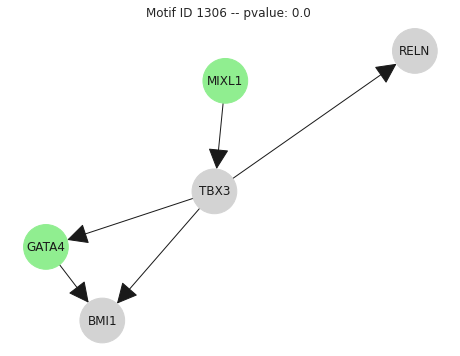

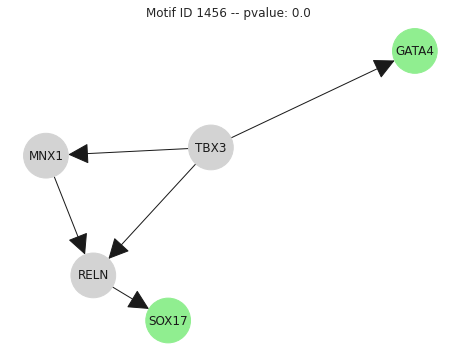

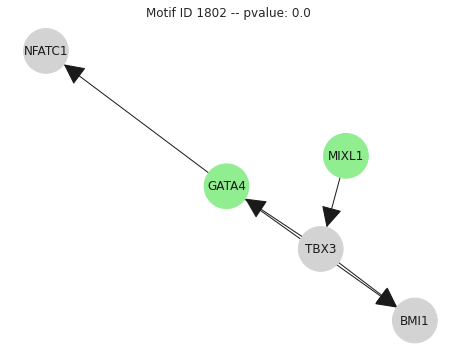

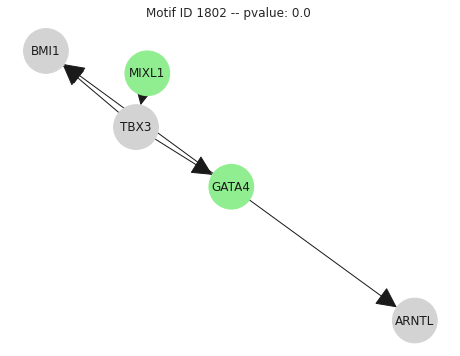

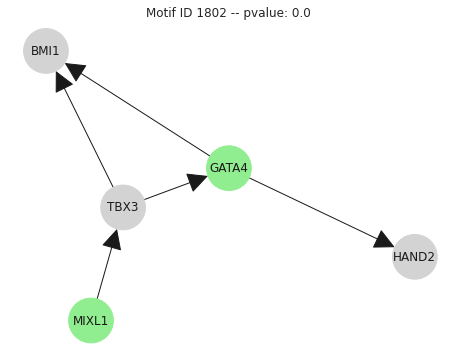

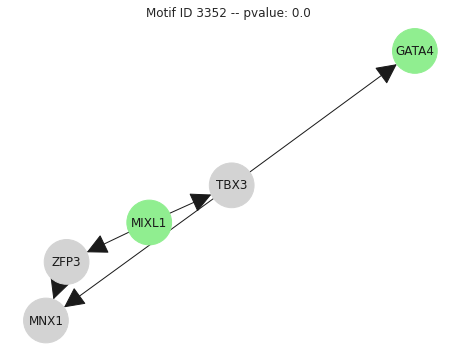

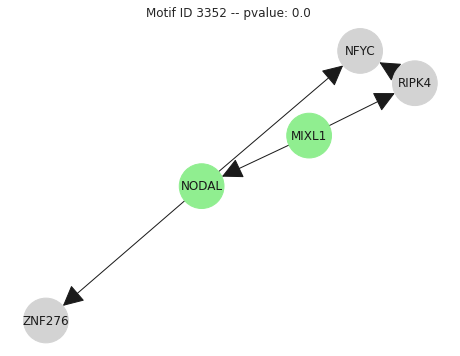

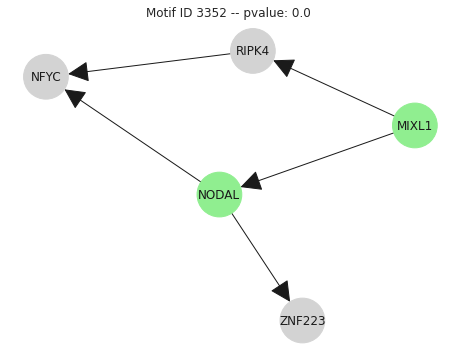

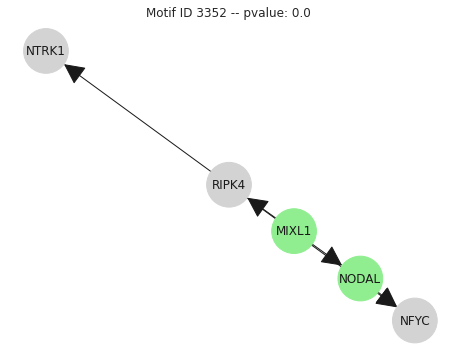

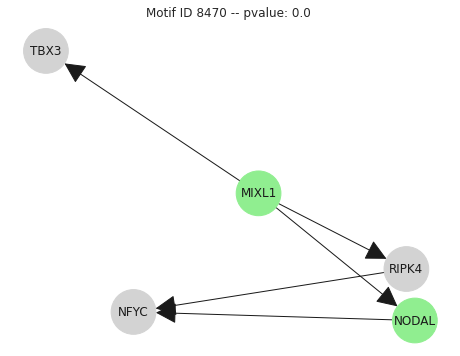

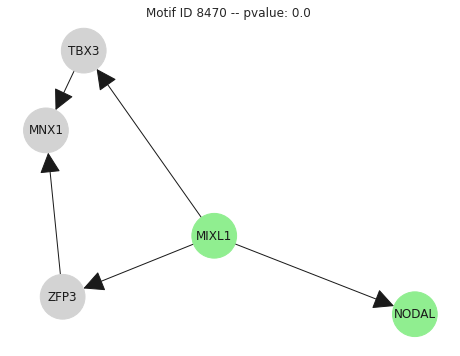

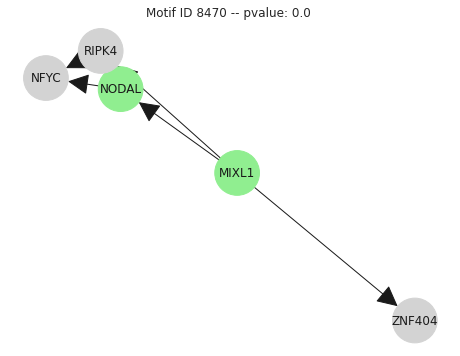

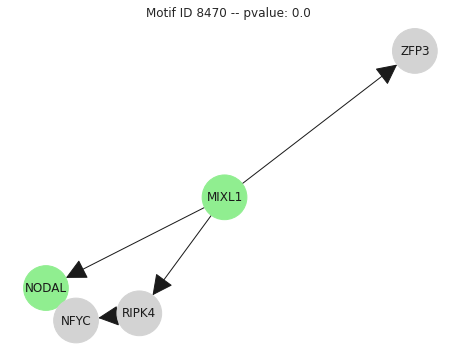

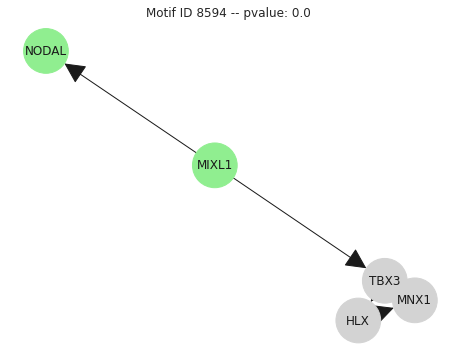

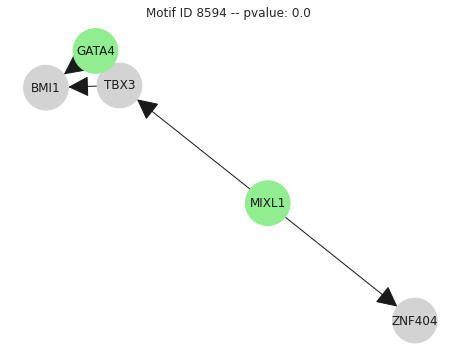

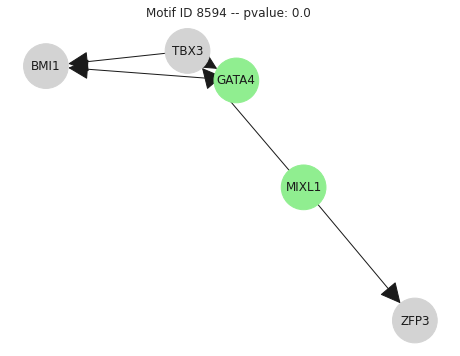

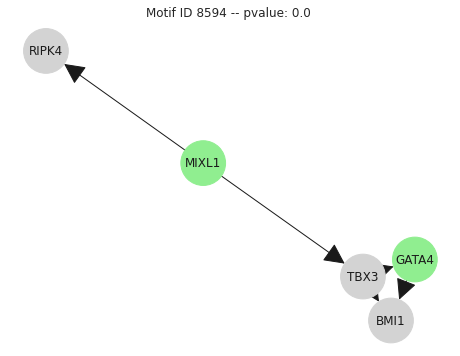

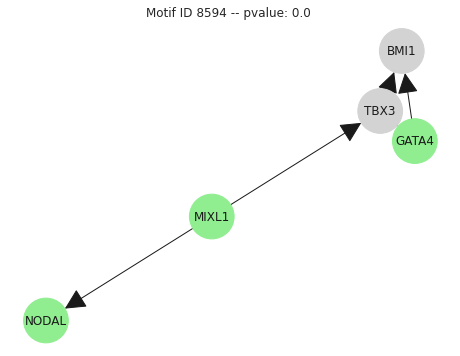

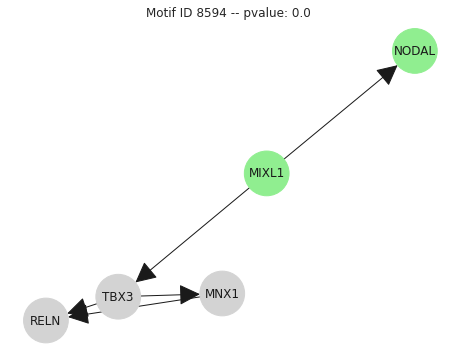

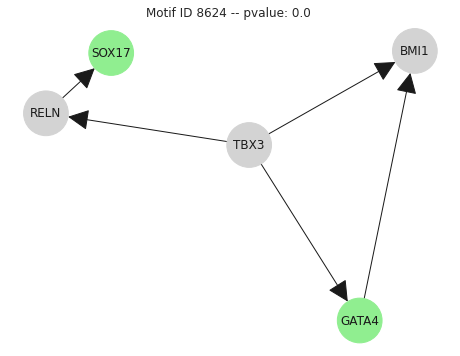

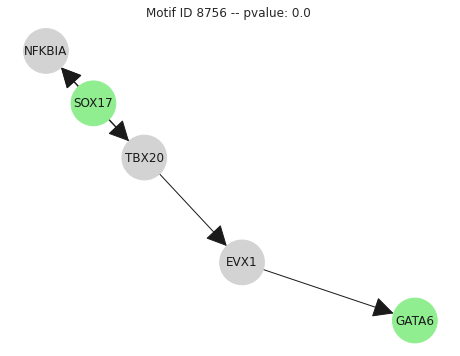

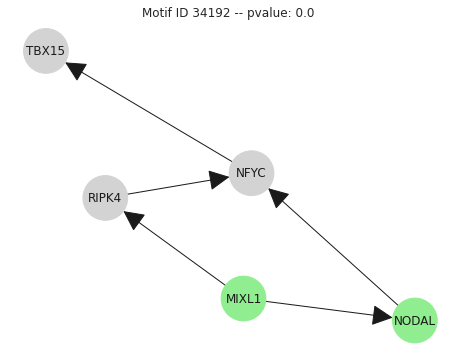

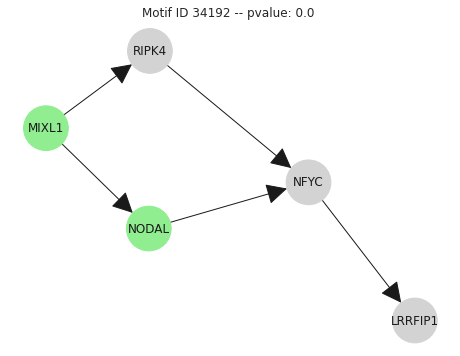

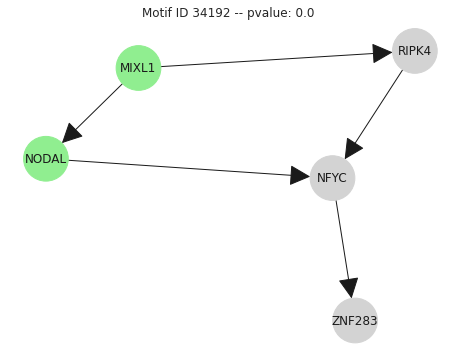

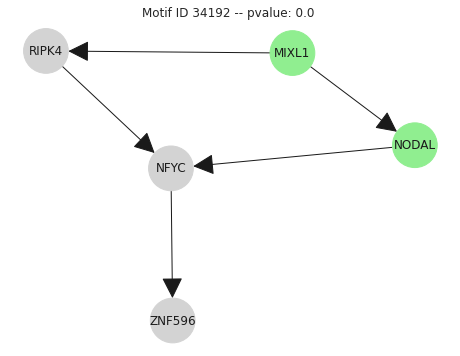

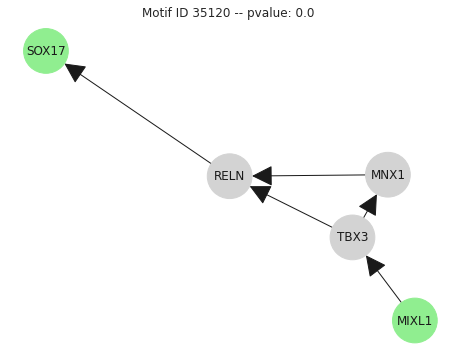

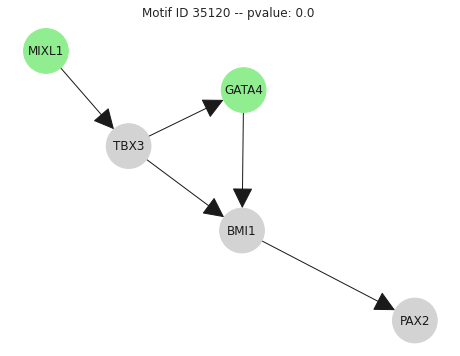

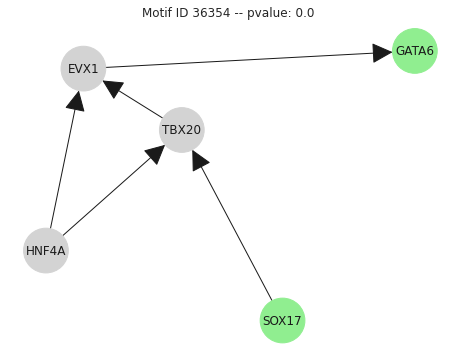

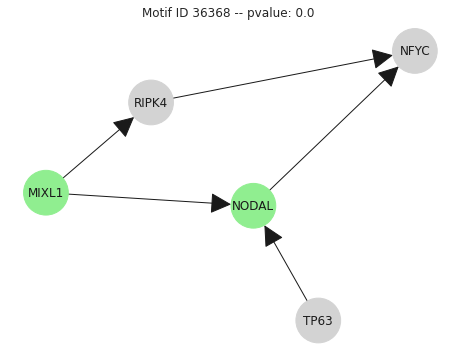

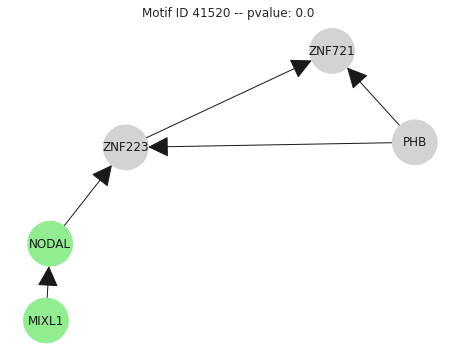

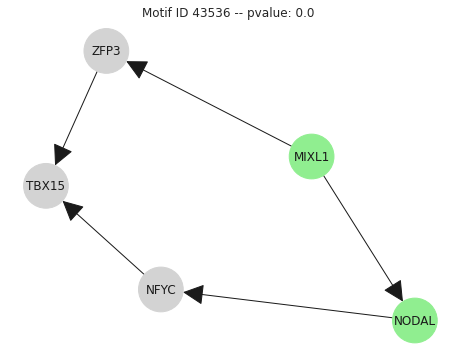

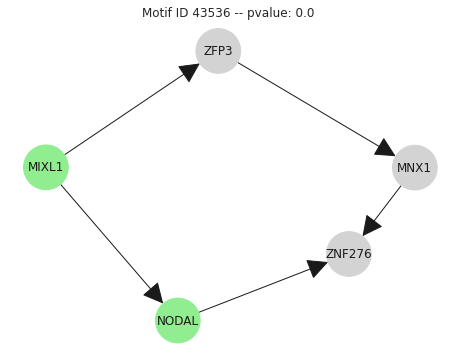

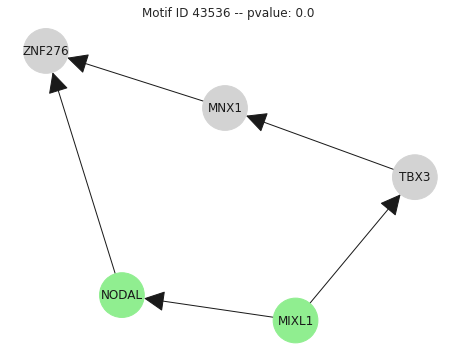

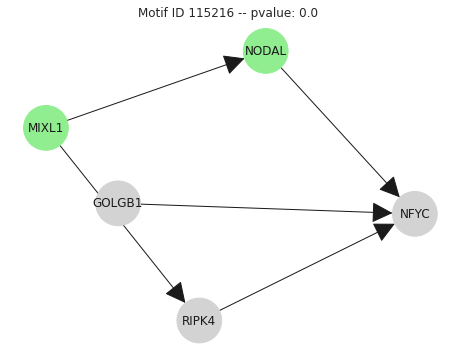

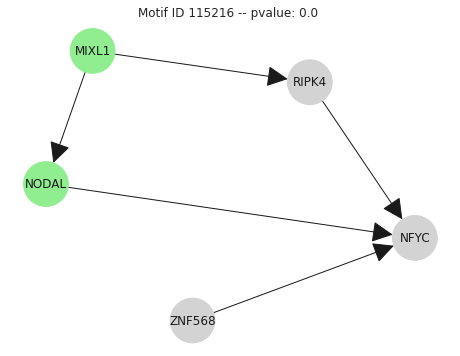

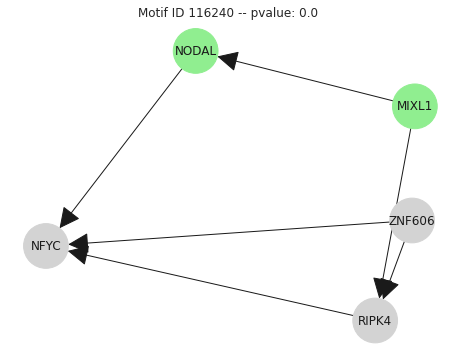

In [181]:
interesting_nodes = []

for intm in interesting_motifs:
    intm.view(node_color = ['lightgreen' if i in gsea_endoderm_enriched_genes else 'lightgrey' for i in intm.members])
    interesting_nodes.extend(intm.members)

## GSEA Subgraph

In [182]:
ensg_hgnc_dict = {k:v for _, (k,v) in hgnc_name_map.reset_index().iterrows()}

In [183]:
full_graph_path = f"{NBDATA_DIR}/iPSC_rna_als_genie_edgelist_0.999.tsv"
full_graph = nx.read_edgelist(full_graph_path,create_using=nx.DiGraph,data=False)
full_graph = nx.relabel_nodes(full_graph, ensg_hgnc_dict)

In [184]:
egograph_list = [nx.ego_graph(full_graph, n, radius=1) for n in interesting_nodes]
# interesting_subgraph = nx.compose_all(egograph_list)
interesting_subgraph = full_graph.subgraph(interesting_nodes)

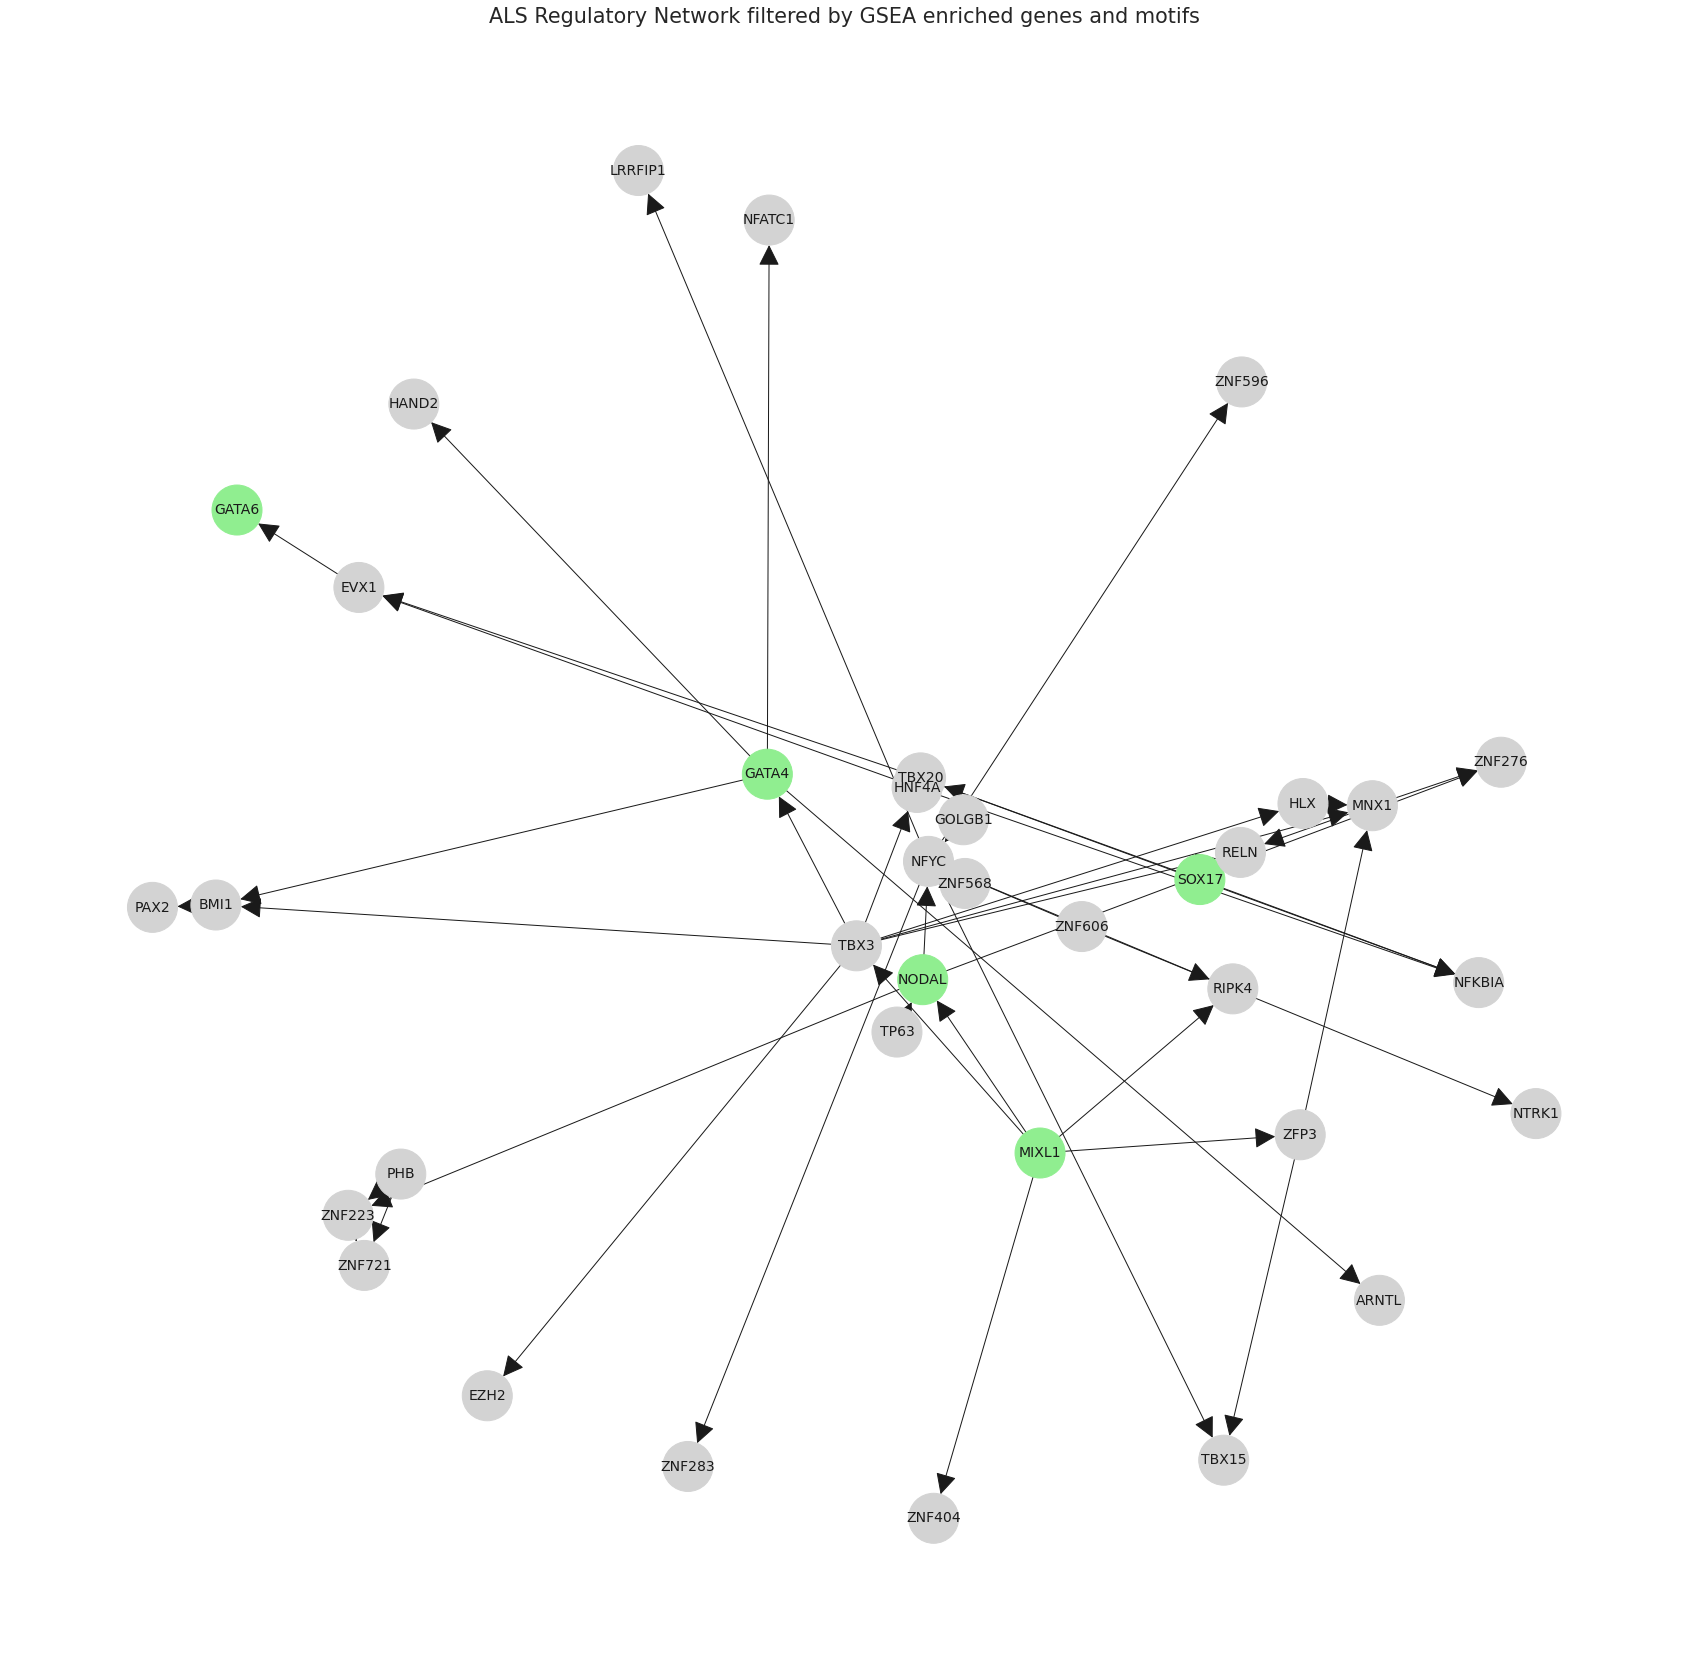

In [185]:
sns.set(style='whitegrid',font_scale=1)
fig, ax1 = plt.subplots(figsize=(30,30))
nx.draw_networkx(interesting_subgraph,
                 arrows=True,
                 arrowsize=45,
                 font_size=14,
                 node_size=2500,
                 node_color=['lightgreen' if i in gsea_endoderm_enriched_genes else 'lightgrey' for i in interesting_subgraph.nodes],
                 ax=ax1,
                 random_state=52,
                )
plt.axis('off')
plt.title('ALS Regulatory Network filtered by GSEA enriched genes and motifs',fontsize='xx-large')
plt.savefig(f"{FIG_DIR}/iPSC_GSEA_interesting_subgraph.png",bbox_inches='tight')
plt.show()